<a href="https://colab.research.google.com/github/achaterlea/london_data/blob/master/ACL_House_Price_Modelling_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London house price modelling
## GA DAT-24 final project 
Andy Chater-Lea

The goal of my project is to model house prices and use my models to identify areas in London where houses are underpriced relative to the 'normal' trend. I am aiming to build and refine a number of different models to predict average house prices at a LSOA - level. LSOAs ()or lower super output areas) are the smallest unit of measurement used in the 2011 census and are drawn geographically to include ~600 dwellings. I will be using census data and other publically available data I have gathered about about london at this level of granularity. Once I have a few different models up and running I should be able to identify outlier LSOAs from each model with the greatest negative residuals which would indicate areas which are underpriced relative to the models and therefore also possibly underpriced in reality.

## 1. Data collection and preparation

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

%matplotlib inline

In [0]:
#Import data and check the head. I will primarily be using census data from the most recent (2011) census.
df = pd.read_csv("https://raw.githubusercontent.com/achaterlea/london_data/master/LSOAdata11.csv", encoding = "ISO-8859-1")

In [172]:
df.set_index(['LSOA'], inplace = True)
df.head()

,Name,All Ages,0-15,16-29,30-44,45-64,65+,Working-age,Working age %,Area (Hectares),...,Average PTAL Score,% 0-1 (poor access),% 2-3 (average access),% 4-6 (good access),Total Number of Children,Total Number of Families Claiming Benefit,Number of families with 3+ children,% of families with 3+ children,Mean Annual Household Income estimate,Median Annual Household Income estimate
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000907,Camden 001A,1430,295,257,372,343,163,972,67.972,10.7,...,4.6,0.0,54.1,45.9,315,180,35,19.4,39985,30223
E01000908,Camden 001B,1581,292,240,431,407,211,1078,68.185,17.5,...,2.9,33.7,66.3,0.0,260,160,20,12.5,42394,32049
E01000909,Camden 001C,1614,244,291,328,462,289,1081,66.976,22.9,...,3.3,0.0,100.0,0.0,185,115,15,13.0,77370,58469
E01000912,Camden 001D,1589,260,356,352,395,226,1103,69.415,89.6,...,4.6,0.0,58.4,41.6,290,160,30,18.8,41737,31551
E01000913,Camden 001E,1710,292,220,343,522,333,1085,63.450,161.7,...,2.8,27.8,71.8,0.5,190,105,20,19.0,96649,73024


In [173]:
#Save copy of my original data in case I need to refer to it again.
df_source = df

#Remove nil entries in the target variable. No price corresponds to no sales data so these would distort my model.
df = df[df['Median price 2011']!=0]

print('Original shape: ',df_source.shape)
print('New shape: ', df.shape)
df.head()

Original shape:  (4835, 91)
New shape:  (4822, 91)


,Name,All Ages,0-15,16-29,30-44,45-64,65+,Working-age,Working age %,Area (Hectares),...,Average PTAL Score,% 0-1 (poor access),% 2-3 (average access),% 4-6 (good access),Total Number of Children,Total Number of Families Claiming Benefit,Number of families with 3+ children,% of families with 3+ children,Mean Annual Household Income estimate,Median Annual Household Income estimate
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000907,Camden 001A,1430,295,257,372,343,163,972,67.972,10.7,...,4.6,0.0,54.1,45.9,315,180,35,19.4,39985,30223
E01000908,Camden 001B,1581,292,240,431,407,211,1078,68.185,17.5,...,2.9,33.7,66.3,0.0,260,160,20,12.5,42394,32049
E01000909,Camden 001C,1614,244,291,328,462,289,1081,66.976,22.9,...,3.3,0.0,100.0,0.0,185,115,15,13.0,77370,58469
E01000912,Camden 001D,1589,260,356,352,395,226,1103,69.415,89.6,...,4.6,0.0,58.4,41.6,290,160,30,18.8,41737,31551
E01000913,Camden 001E,1710,292,220,343,522,333,1085,63.450,161.7,...,2.8,27.8,71.8,0.5,190,105,20,19.0,96649,73024


In my initial EDA I identified that some of the strongest positive and negative correlations with house prices within the data were measurements of income or other indicators of economic wealth such as car ownership or numbers of residents per dwelling. Obviously wealthy people can afford more expensive houses.

I am looking to identify trends and create models based on other properties of an area (such as access to transport, healthcare, education and crime rates etc) as opposed to the economic status of people currently living there, so I will split these fields away from my main dataframe. 

There are also multiple fields which are expressed both as a percentage and as an absolute number, I will remove the absolute number versions of these fields as LSOAs are not all equally sized.


In [174]:
print(df.columns)

Index(['Name', 'All Ages', '0-15', '16-29', '30-44', '45-64', '65+',
       'Working-age', 'Working age %', 'Area (Hectares)',
       'Persons per Hectare 2011', 'Number of households',
       'Couple household with dependent children',
       'Couple household without dependent children', 'Lone parent household',
       'One person household', 'Other household Types',
       '% Couple household with dependent children',
       '% Couple household without dependent children',
       '% Lone parent household', '% One person household',
       '% Other multi person household', 'Owned outright',
       'Owned with a mortgage or loan', 'Social rented', 'Private rented',
       'Owned outright (%)', 'Owned with a mortgage or loan (%)',
       'Social rented (%)', 'Private rented (%)', 'All Households',
       'Household spaces with at least one usual resident',
       'Household spaces with no usual residents',
       'Whole house or bungalow: Detached',
       'Whole house or bungalow: Sem

In [175]:
#Print full column names and indices to identify unwanted features
print([z for z in zip(range(len(df_source.columns)), df_source.columns)])

[(0, 'Name'), (1, 'All Ages'), (2, '0-15'), (3, '16-29'), (4, '30-44'), (5, '45-64'), (6, '65+'), (7, 'Working-age'), (8, 'Working age %'), (9, 'Area (Hectares)'), (10, 'Persons per Hectare 2011'), (11, 'Number of households'), (12, 'Couple household with dependent children'), (13, 'Couple household without dependent children'), (14, 'Lone parent household'), (15, 'One person household'), (16, 'Other household Types'), (17, '% Couple household with dependent children'), (18, '% Couple household without dependent children'), (19, '% Lone parent household'), (20, '% One person household'), (21, '% Other multi person household'), (22, 'Owned outright'), (23, 'Owned with a mortgage or loan'), (24, 'Social rented'), (25, 'Private rented'), (26, 'Owned outright (%)'), (27, 'Owned with a mortgage or loan (%)'), (28, 'Social rented (%)'), (29, 'Private rented (%)'), (30, 'All Households'), (31, 'Household spaces with at least one usual resident'), (32, 'Household spaces with no usual residents

In [176]:
#Drop the columns I will be ommitting
df = df.drop(df.columns[[0,2,3,4,5,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,31,32,33,34,35,36,
                         43,44,46,47,48,49,50,51,52,53,54,57,58,59,60,61,62,63,64,76,77,78,
                         79,80,86,87,88,89,90]], axis = 1)
df.columns

Index(['All Ages', 'Working age %', 'Area (Hectares)',
       'Persons per Hectare 2011', 'Number of households',
       'Owned outright (%)', 'Owned with a mortgage or loan (%)',
       'Social rented (%)', 'Private rented (%)',
       'Household spaces with at least one usual resident (%)',
       'Household spaces with no usual residents (%)',
       'Whole house or bungalow: Detached (%)',
       'Whole house or bungalow: Semi-detached (%)',
       'Whole house or bungalow: Terraced (including end-terrace) (%)',
       'Flat, maisonette or apartment (%)', 'Median price 2011',
       'Employment Rate', 'Unemployment Rate', '% No qualifications',
       '% Highest level of qualification: Level 1 qualifications',
       '% Highest level of qualification: Level 2 qualifications',
       '% Highest level of qualification: Apprenticeship',
       '% Highest level of qualification: Level 3 qualifications',
       '% Highest level of qualification: Level 4 qualifications and above',
      

Skew:  4.275245179593808 Kurtosis:  32.03828139091149


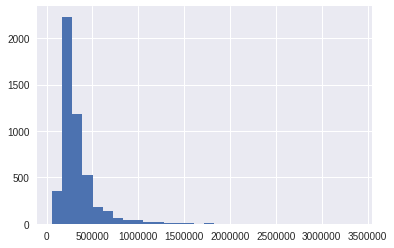

In [177]:
#In my EDA I identified that the target variable of Median price 2011 was skewed, as shown below.
df['Median price 2011'].hist(bins = 30)
print('Skew: ',skew(df['Median price 2011']),'Kurtosis: ',kurtosis(df['Median price 2011']))

Skew:  1.0074464281009998 Kurtosis:  1.767257854154055


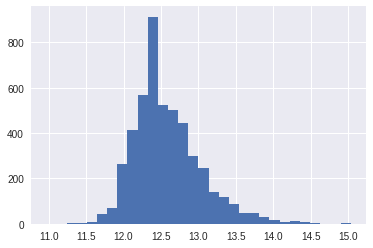

In [178]:
#As you can see, highly skewed data with a significant tail.
#A log transformation is able to substantially resolve this skew and kurtosis, as shown below.
df['log_price'] = np.log(df['Median price 2011'])
df["log_price"].hist(bins = 30)
print('Skew: ',skew(df['log_price']),'Kurtosis: ',kurtosis(df['log_price']))

In [179]:
#Note - this has resolved the skew, however the kurtosis is 1.77 whereas it should be ~3 in a Normal distribution
#I will split the price data into a separate dataframe to be able to merge onto other sources
df_price = df[['Median price 2011','log_price']]
df_price.head()

,Median price 2011,log_price
LSOA,,
E01000907,415000,12.936034
E01000908,282500,12.551434
E01000909,435000,12.983101
E01000912,500000,13.122363
E01000913,1000000,13.815511


In [180]:
#To try to make up for omitting a large chunk of my original census data, I have obtained data on the dwelling makeup
#of each LSOA, I will extract some key columns from here to add to my analysis.

df_types = pd.read_csv("https://raw.githubusercontent.com/achaterlea/london_data/master/PropertyTypes.csv")
df_types.set_index('LSOA', inplace = True)
df_types.head()

,NAME,TYPE_BUNGALOW_1,TYPE_BUNGALOW_2,TYPE_BUNGALOW_3,TYPE_BUNGALOW_4,TYPE_BUNGALOW_UNKW,BUNGALOW,TYPE_FLAT_MAIS_1,TYPE_FLAT_MAIS_2,TYPE_FLAT_MAIS_3,...,BP_1955_1964,BP_1965_1972,BP_1973_1982,BP_1983_1992,BP_1993_1999,BP_2000_2009,BP_2010_2015,BP_UNKNOWN,ALL_PROPERTIES.1,WAVG_AGE
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,0,0,0,0,0,0,450,350,210,...,50,840,10,0,50,80,0,10,1100,50.83
E01000002,City of London 001B,0,0,0,0,0,0,630,320,110,...,70,910,0,10,0,0,200,0,1190,43.70
E01000003,City of London 001C,0,0,0,0,0,0,540,240,20,...,20,780,0,0,60,40,0,0,910,48.58
E01000005,City of London 001E,0,0,0,0,0,0,330,200,130,...,140,110,170,70,0,10,70,0,680,54.18
E01000006,Barking and Dagenham 016A,0,0,0,0,0,0,90,50,0,...,0,0,0,0,130,10,0,0,530,74.72


In [181]:
# connect with the house prices to identify correlations
df_types = df_types.join(df_price, how = 'inner')
df_types.head()

,NAME,TYPE_BUNGALOW_1,TYPE_BUNGALOW_2,TYPE_BUNGALOW_3,TYPE_BUNGALOW_4,TYPE_BUNGALOW_UNKW,BUNGALOW,TYPE_FLAT_MAIS_1,TYPE_FLAT_MAIS_2,TYPE_FLAT_MAIS_3,...,BP_1973_1982,BP_1983_1992,BP_1993_1999,BP_2000_2009,BP_2010_2015,BP_UNKNOWN,ALL_PROPERTIES.1,WAVG_AGE,Median price 2011,log_price
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,0,0,0,0,0,0,450,350,210,...,10,0,50,80,0,10,1100,50.83,505000,13.132314
E01000002,City of London 001B,0,0,0,0,0,0,630,320,110,...,0,10,0,0,200,0,1190,43.70,525000,13.171154
E01000003,City of London 001C,0,0,0,0,0,0,540,240,20,...,0,0,60,40,0,0,910,48.58,350000,12.765688
E01000005,City of London 001E,0,0,0,0,0,0,330,200,130,...,170,70,0,10,70,0,680,54.18,300000,12.611538
E01000006,Barking and Dagenham 016A,0,0,0,0,0,0,90,50,0,...,0,0,130,10,0,0,530,74.72,240500,12.390475


In [182]:
#Check correlations to target variable.
df_types.corr()['log_price'].sort_values()

TYPE_HOUSE_TERRACED_3          -0.283238
TYPE_HOUSE_TERRACED_2          -0.267384
HOUSE_TERRACED                 -0.230766
3_BED                          -0.209080
BP_1973_1982                   -0.142389
BP_1955_1964                   -0.131161
BP_1945_1954                   -0.122528
TYPE_HOUSE_SEMI_2              -0.122142
BP_1965_1972                   -0.121661
2_BED                          -0.116500
TYPE_BUNGALOW_1                -0.098714
BP_1983_1992                   -0.091885
TYPE_HOUSE_TERRACED_1          -0.068649
BP_1919_1929                   -0.065101
TYPE_HOUSE_SEMI_1              -0.053278
BP_1993_1999                   -0.052901
TYPE_HOUSE_SEMI_3              -0.050239
BP_1930_1939                   -0.049853
BP_2000_2009                   -0.043145
ANNEXE                         -0.034706
BP_2010_2015                   -0.034483
TYPE_BUNGALOW_2                -0.033217
BUNGALOW                       -0.031595
OTHER                          -0.004733
TYPE_BUNGALOW_UN

In [0]:
#In the above data, an underscore followed by a number represents the numbers of rooms in each type of property
#My data already has information on the number and proportion of different types of housing however it doesn't include
#data on average no of rooms or age of properties. I will extract the averages of each of these as well as the absolute
#number of properties with each number of rooms to add to my data. Also if a property was built pre 1900 has a .37 correlation so may also be useful
df_keytypes = df_types[['W_AVG_ROOMS','WAVG_AGE','4_BED','3_BED','2_BED','1_BED','BP_PRE_1900']]

df = df.join(df_keytypes, how = 'inner')

In [184]:
#I will also add in crime data I have obtained separately
df_crime = pd.read_csv("https://raw.githubusercontent.com/achaterlea/london_data/master/LSOA_Crime.csv")
df_crime = df_crime.set_index('LSOA')
df_crime.head()

,Major Category,Crimes_2008,Crimes_2009,Crimes_2010,Crimes_2011,Crimes_2012,Crimes_2013,Crimes_2014,Crimes_2015,Crimes_2016,4_YRS_TO_2011,3_YRS_TO_2011,2_YRS_TO_2011
LSOA,,,,,,,,,,,,,
E01000001,Burglary,0,0,0,0,1,0,0,0,0,0,0,0
E01000001,Violence Against the Person,0,0,0,0,0,0,0,1,0,0,0,0
E01000001,Criminal Damage,0,0,0,0,0,1,0,0,0,0,0,0
E01000001,Drugs,0,0,0,0,0,0,0,1,0,0,0,0
E01000001,Violence Against the Person,0,0,0,0,0,0,0,1,0,0,0,0


In [185]:
#LSOAs appear to have multiple entries for each category. I need to group for a total by LSOA (although this loses the granularity of what crime was committed)
df_crime = df_crime.groupby(by = ['LSOA']).sum()
df_crime.head()

,Crimes_2008,Crimes_2009,Crimes_2010,Crimes_2011,Crimes_2012,Crimes_2013,Crimes_2014,Crimes_2015,Crimes_2016,4_YRS_TO_2011,3_YRS_TO_2011,2_YRS_TO_2011
LSOA,,,,,,,,,,,,
E01000001,0,0,0,2,6,6,6,9,6,2,2,2
E01000002,0,0,0,7,10,3,2,9,20,7,7,7
E01000003,0,0,0,0,3,3,1,9,15,0,0,0
E01000005,0,0,0,9,23,35,24,20,12,9,9,9
E01000006,105,91,117,99,96,94,72,82,79,412,307,216


In [186]:
#Before 2011 some LSOAs did not exist and some boundaries were redrawn, therefore we drop all columns relating 
#to older data

df_crime = df_crime.drop(columns = ['Crimes_2008','Crimes_2009','Crimes_2010','4_YRS_TO_2011', '3_YRS_TO_2011', '2_YRS_TO_2011'], 
              axis = 0)

df_crime.describe()

,Crimes_2011,Crimes_2012,Crimes_2013,Crimes_2014,Crimes_2015,Crimes_2016
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,149.930714,152.498242,141.966287,140.679007,147.181799,152.248397
std,219.494586,228.208652,209.628013,188.927110,194.566705,197.729749
min,0.000000,3.000000,3.000000,1.000000,9.000000,6.000000
25%,76.000000,76.000000,70.000000,71.000000,72.000000,73.000000
50%,110.000000,108.000000,101.000000,101.000000,106.000000,108.000000
75%,161.000000,159.000000,149.000000,151.000000,158.000000,163.000000
max,7279.000000,6617.000000,6081.000000,5309.000000,4985.000000,5047.000000


1
Skew:  15.358566011385268 Kurtosis:  382.2791852423906


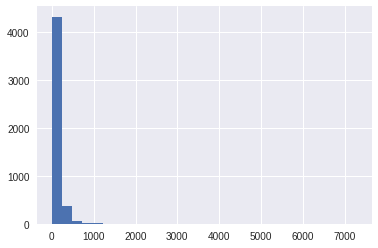

In [187]:
#Crime data also appears to be heavily skewed, we may need another log transformation to resolve.
#Count how many lines I will lose by omitting LSOAs with no crime.
print(sum(df_crime['Crimes_2011'] ==0))

#Review distribution of crime
df_crime['Crimes_2011'].hist(bins = 30)
print('Skew: ',skew(df_crime['Crimes_2011']),'Kurtosis: ',kurtosis(df_crime['Crimes_2011']))

Skew:  0.2750209359578144 Kurtosis:  2.8819542409031618


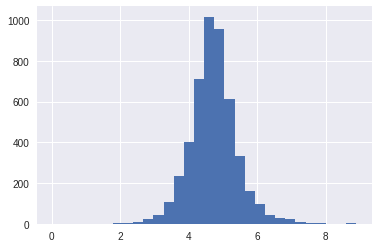

In [188]:
#Another log transformation should resolve the skew.
df_crime = df_crime[df_crime['Crimes_2011']!=0]
df_crime= np.log(df_crime)
df_crime['Crimes_2011'].hist(bins = 30)
print('Skew: ',skew(df_crime['Crimes_2011']),'Kurtosis: ',kurtosis(df_crime['Crimes_2011']))

In [189]:
df_crime = df_crime.join(df_price, how = 'inner')

df_crime.corr()['log_price'].sort_values()

Crimes_2016         -0.093915
Crimes_2015         -0.093787
Crimes_2014         -0.084747
Crimes_2013         -0.067313
Crimes_2011         -0.061790
Crimes_2012         -0.046967
Median price 2011    0.908815
log_price            1.000000
Name: log_price, dtype: float64

Crimes are extremely weakly negatively correlated with house prices. This data doesn't seem too useful for linear regression but may help if I perform clustering later. I will check correlations of crime over the 3 years to 2013 to see if it would be useful adding all 3

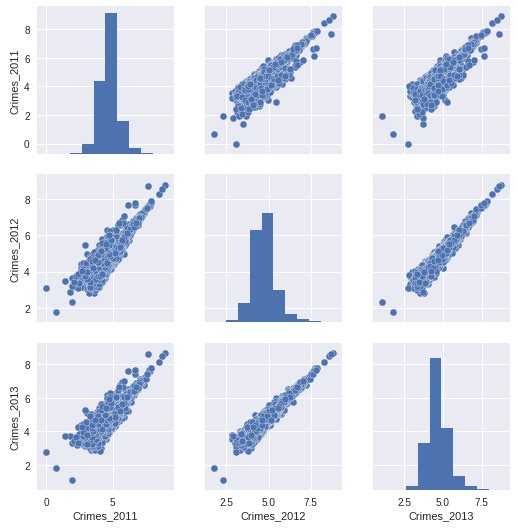

In [190]:
sns.pairplot(data = df_crime[['Crimes_2011','Crimes_2012','Crimes_2013']])

In [0]:
#All 3 years are very closely correlated, I will add 2011 only as this matches the timing of my other data
#I will also use a set to rename the column names to be shorter
df = df.join(df_crime[['Crimes_2011']], how = 'inner')
df.rename(columns = {
    'Persons per Hectare 2011':'Population density',
    'Owned with a mortgage or loan (%)':'Owned mortgaged (%)',
    'Household spaces with at least one usual resident (%)':'Usual residents (%)',
    'Household spaces with no usual residents (%)':'No usual residents (%)',
    'Whole house or bungalow: Detached (%)': 'Detached (%)',
    'Whole house or bungalow: Semi-detached (%)': 'Semi-detatched (%)',
    'Whole house or bungalow: Terraced (including end-terrace) (%)': 'Terraced (%)',
    'Flat, maisonette or apartment (%)': 'Flats etc (%)',
    '% No qualifications' : 'Ed: No qualifications (%)',
    '% Highest level of qualification: Level 1 qualifications':'Ed: GCSE D-F (%)',
    '% Highest level of qualification: Level 2 qualifications': 'Ed: GCSE A-C (%)',
    '% Highest level of qualification: Apprenticeship': 'Ed: Apprentice (%)',
    '% Highest level of qualification: Level 3 qualifications' : 'Ed: A-Level (%)',
    '% Highest level of qualification: Level 4 qualifications and above': 'Ed: Higher (%)',
    '% Highest level of qualification: Other qualifications': 'Ed: Other (%)',
    '% Schoolchildren and full-time students: Age 18 and over': 'Schoolchildren (%)',
    'Very good or Good health (%)' : 'Good health (%)',
    'Bad or Very Bad health (%)' :'Bad health (%)',
    '% 0-1 (poor access)':'Poor PTAL (%)','% 2-3 (average access)' :'Average PTAL (%)',
    '% 4-6 (good access)':'Good PTAL (%)','Total Number of Children' : 'No. of Children',
    'Crimes_2011': 'log_crime'}, inplace = True)

In [192]:
#Review total dataset for correlated features 
df.corr()['log_price'].sort_values()

Ed: GCSE D-F (%)            -0.649566
Ed: No qualifications (%)   -0.622249
No. of Children             -0.612148
Unemployment Rate           -0.540839
Fair health (%)             -0.505908
Ed: GCSE A-C (%)            -0.476964
Usual residents (%)         -0.419329
Bad health (%)              -0.384041
Social rented (%)           -0.312701
Ed: Apprentice (%)          -0.273868
3_BED                       -0.209005
Terraced (%)                -0.206896
Ed: Other (%)               -0.163848
All Ages                    -0.154596
Average PTAL (%)            -0.137471
2_BED                       -0.116519
Poor PTAL (%)               -0.106496
Schoolchildren (%)          -0.072164
Ed: A-Level (%)             -0.068660
log_crime                   -0.061790
Semi-detatched (%)          -0.043821
Owned mortgaged (%)         -0.027149
Area (Hectares)              0.022571
Population density           0.047647
Number of households         0.058518
1_BED                        0.065749
Flats etc (%

In [193]:
df.columns

Index(['All Ages', 'Working age %', 'Area (Hectares)', 'Population density',
       'Number of households', 'Owned outright (%)', 'Owned mortgaged (%)',
       'Social rented (%)', 'Private rented (%)', 'Usual residents (%)',
       'No usual residents (%)', 'Detached (%)', 'Semi-detatched (%)',
       'Terraced (%)', 'Flats etc (%)', 'Median price 2011', 'Employment Rate',
       'Unemployment Rate', 'Ed: No qualifications (%)', 'Ed: GCSE D-F (%)',
       'Ed: GCSE A-C (%)', 'Ed: Apprentice (%)', 'Ed: A-Level (%)',
       'Ed: Higher (%)', 'Ed: Other (%)', 'Schoolchildren (%)',
       'Good health (%)', 'Fair health (%)', 'Bad health (%)',
       'Average PTAL Score', 'Poor PTAL (%)', 'Average PTAL (%)',
       'Good PTAL (%)', 'No. of Children', 'log_price', 'W_AVG_ROOMS',
       'WAVG_AGE', '4_BED', '3_BED', '2_BED', '1_BED', 'BP_PRE_1900',
       'log_crime'],
      dtype='object')

It appears that the strongest negative correlations correspond to poor health and education, unemployment, socially rented housing and average to poor PTAL access (0-3). Whilst likely to be cocorrelated to some degree as they are all indicators of lower economic status they may provide enough variance for a linear model. The strongest positive correlations are good education, number of 4 bed properties, good health (fair health is more negative), employment rate (although unemployment is stronger negative), weighted average age, good PTAL score (stronger than the negative).

## 2. Test, train and validation data splits

I will define a master train_test_split so I have some of my data left aside to test my model on and then define a second split to identify my validation set. I am including both the log and the normal median price as there may be some models which don't require normally distrbuted target variables (for example decision tree and random forest based models). Given the size of the data I will set 25% aside at each step so my models are trained on just over half of the original dataset.

In [194]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
X = df.drop(columns = ['Median price 2011','log_price'], axis = 1)
y = df[['Median price 2011','log_price']]

X_train_master, X_test_master, y_train_master, y_test_master = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train_master.shape,X_test_master.shape)
X_train, X_test, y_train, y_test = train_test_split(X_train_master, y_train_master, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)


(3615, 41) (1206, 41)
(2711, 41) (904, 41)


In [195]:
#In order to split my y_train into series objects I need to split out the different columns and apply a squeeze
yreg_train = y_train.drop(columns = 'log_price', axis = 1).squeeze()
ylog_train = y_train.drop(columns = 'Median price 2011', axis = 1).squeeze()
yreg_test = y_test.drop(columns = 'log_price', axis = 1).squeeze()
ylog_test = y_test.drop(columns = 'Median price 2011', axis = 1).squeeze()

print(yreg_train.shape,ylog_train.shape,yreg_test.shape,ylog_test.shape)

(2711,) (2711,) (904,) (904,)


## 3. Key feature selection for linear modelling

There are a number of features included in my data which may be useful for a linear regression, however many of these are likely to be co-correlated as they relate to proportional scores in fields such as health, education etc. I will select a few fields from each set as features. I will be iterating through combinations of features to find the best set, at this stage it  is uncertain whether positive or negative associations will be the most effective. I will therefore include features from the same field which are negatively correlated with each other, although models with these pairings may not be the most effective.

In [0]:
features = []

In [0]:
def checkfeatures(test):
    test.append('log_price')
    print(df[test].corr()['log_price'].sort_values())
    sns.heatmap(data = df[test].corr())

#### Population:

No. of Children        -0.612148
All Ages               -0.154596
Area (Hectares)         0.022571
Population density      0.047647
Number of households    0.058518
Working age %           0.194554
log_price               1.000000
Name: log_price, dtype: float64


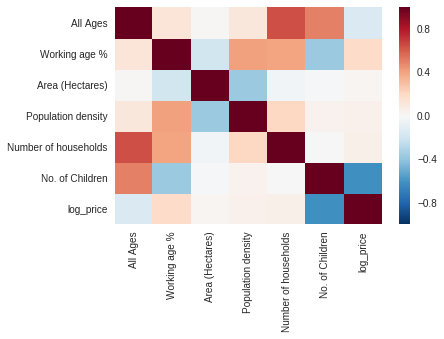

In [198]:
checkfeatures(['All Ages', 'Working age %', 'Area (Hectares)', 'Population density',
               'Number of households','No. of Children'])

In [0]:
#Number of Children features the strongest correlation to log price, most other measures are
#very weak, I will select number of children as my first feature.
features.extend(['No. of Children'])

#### Education:

Ed: GCSE D-F (%)            -0.649566
Ed: No qualifications (%)   -0.622249
Ed: GCSE A-C (%)            -0.476964
Ed: Apprentice (%)          -0.273868
Ed: Other (%)               -0.163848
Schoolchildren (%)          -0.072164
Ed: A-Level (%)             -0.068660
Ed: Higher (%)               0.685825
log_price                    1.000000
Name: log_price, dtype: float64


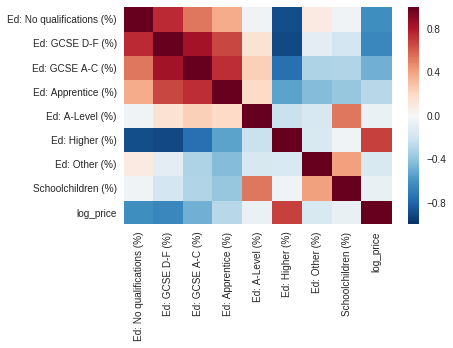

In [200]:
checkfeatures(['Ed: No qualifications (%)', 'Ed: GCSE D-F (%)', 'Ed: GCSE A-C (%)','Ed: Apprentice (%)', 
               'Ed: A-Level (%)', 'Ed: Higher (%)', 'Ed: Other (%)', 'Schoolchildren (%)'])

In [0]:
#The log price is strongly correlated with Higher education and strongly negatively correlated
#with No qualifications and GCSE Fail level. High and low education are negatively correlated 
#with each other so a model with both may not work well, however I will be iterating through
#combinations of features so I will select a strong positive and a strong negative feature.
features.extend(['Ed: Higher (%)','Ed: GCSE D-F (%)'])


#### Employment:

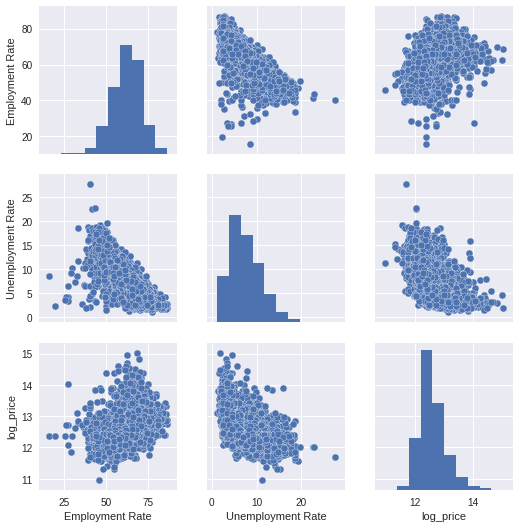

In [202]:
#Only two features here so I will do a pairplot to identify their relationships
sns.pairplot(data = df[['Employment Rate', 'Unemployment Rate','log_price']])

In [0]:
#Obiously employment rate and unemployment rate are negatively correlated.
#At this stage it is unclear which will be most effective so I will include both since they 
#each exhibit some variance.
features.extend(['Employment Rate', 'Unemployment Rate'])

#### Usual residency:

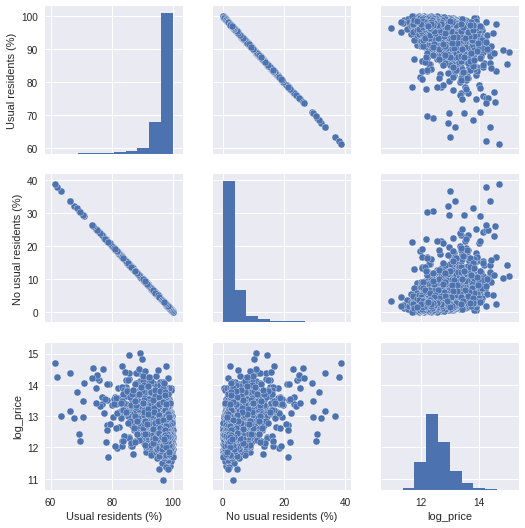

In [204]:
sns.pairplot(data = df[['Usual residents (%)', 'No usual residents (%)', 'log_price']])

In [0]:
#These two features are perfectly negatively correlated therefore only one is needed.
#I will include households with no usual residents as this has the positive correlation, and
#intuitively higher proprotion of short term lets (or vacant plots) corresponding to higher property prices
#makes sense due to new builds at the time of the census

features.extend(['No usual residents (%)'])

#### House ownership:

Social rented (%)     -0.312701
Owned mortgaged (%)   -0.027149
Private rented (%)     0.182123
Owned outright (%)     0.338408
log_price              1.000000
Name: log_price, dtype: float64


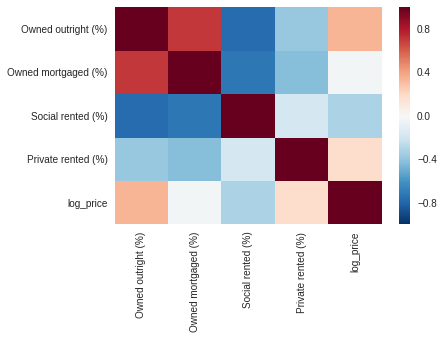

In [206]:
checkfeatures(['Owned outright (%)', 'Owned mortgaged (%)', 'Social rented (%)', 
                       'Private rented (%)'])

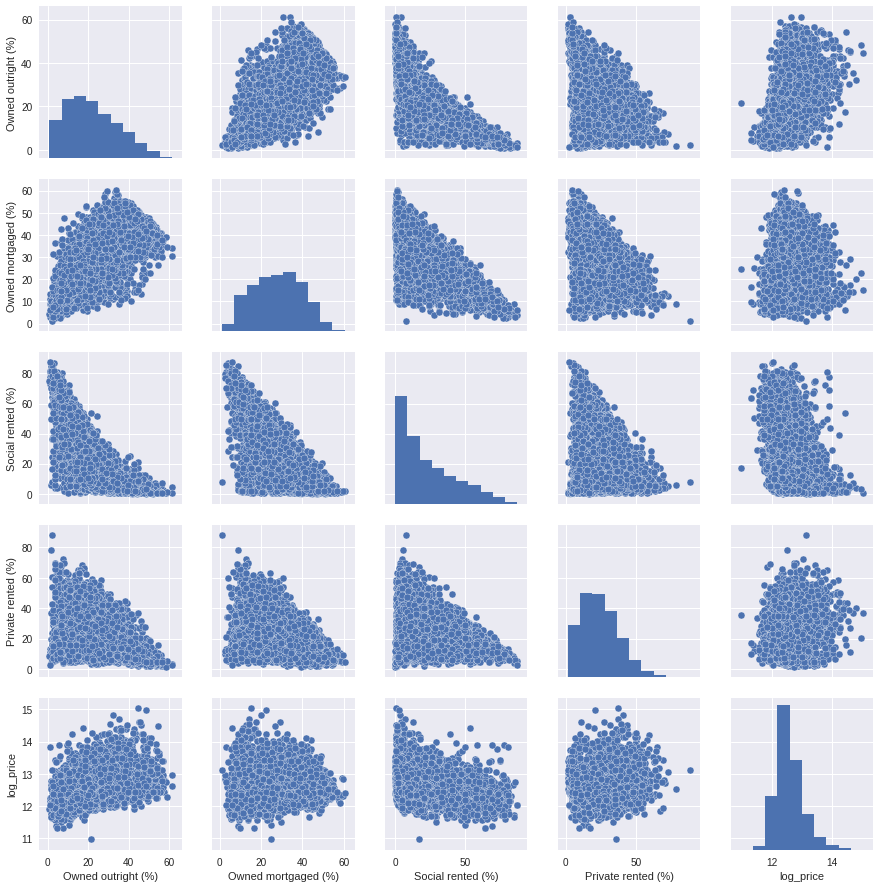

In [207]:
sns.pairplot(data = df[['Owned outright (%)', 'Owned mortgaged (%)', 'Social rented (%)', 
                       'Private rented (%)','log_price']])

In [0]:
#Social rented and owned outright have the strongest negative and positive correlations, they are negatively
#correlated with each other but may prove useful due to the variance.
features.extend(['Social rented (%)', 'Owned outright (%)'])

#### House type:

Terraced (%)         -0.206896
Semi-detatched (%)   -0.043821
Flats etc (%)         0.089600
Detached (%)          0.194777
WAVG_AGE              0.347462
BP_PRE_1900           0.375453
log_price             1.000000
Name: log_price, dtype: float64


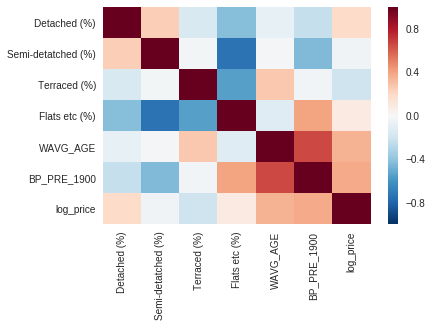

In [209]:
checkfeatures(['Detached (%)','Semi-detatched (%)', 'Terraced (%)', 'Flats etc (%)','WAVG_AGE', 'BP_PRE_1900'])

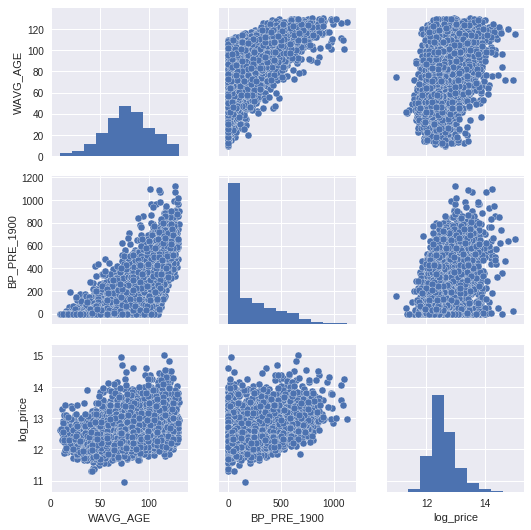

In [210]:
#Terraced and detached % give the strongest negative and positive correlations by property type. 
features.extend(['Terraced (%)','Detached (%)'])

#Age-wise either weighted average age or number of properties with build period pre 1900 could work.
sns.pairplot(data = df[['WAVG_AGE', 'BP_PRE_1900','log_price']])

In [0]:
#Weighted average age is much more normal so I will use it.
features.append('WAVG_AGE')

#### Property size:

3_BED         -0.209005
2_BED         -0.116519
1_BED          0.065749
W_AVG_ROOMS    0.188247
4_BED          0.556781
log_price      1.000000
Name: log_price, dtype: float64


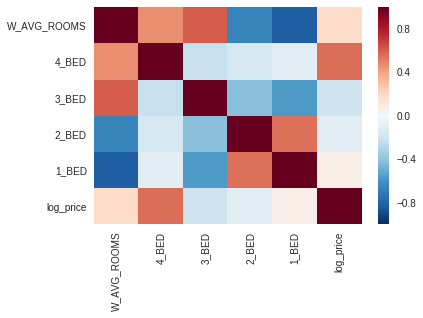

In [212]:
checkfeatures(['W_AVG_ROOMS', '4_BED', '3_BED', '2_BED', '1_BED'])

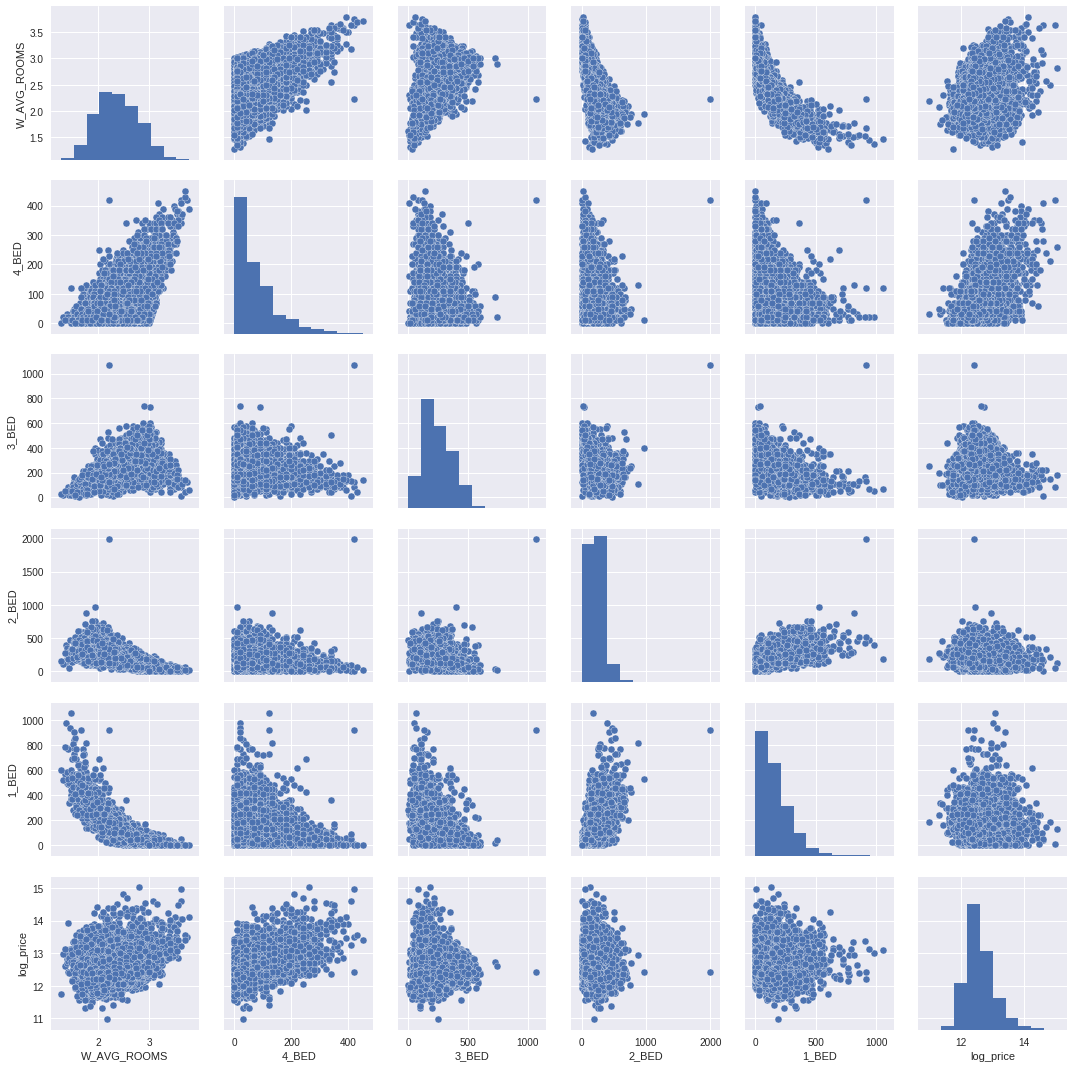

In [213]:
sns.pairplot(data = df[['W_AVG_ROOMS', '4_BED', '3_BED', '2_BED', '1_BED','log_price']])

In [0]:
#Count of 4 bed properties is the strongest correlation but is not normal, weighted average is more normal but shows
#a weaker correlation. Obivously the two are correlated, I will try both and see which is more effective.

features.extend(['W_AVG_ROOMS', '4_BED'])

#### Health:

Fair health (%)   -0.505908
Bad health (%)    -0.384041
Good health (%)    0.490238
log_price          1.000000
Name: log_price, dtype: float64


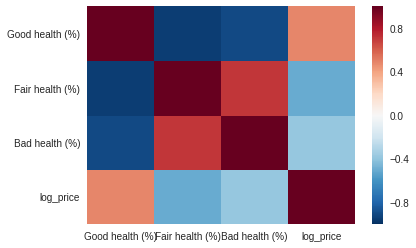

In [215]:
checkfeatures(['Good health (%)','Fair health (%)', 'Bad health (%)'])

In [0]:
features.extend(['Good health (%)', 'Fair health (%)'])

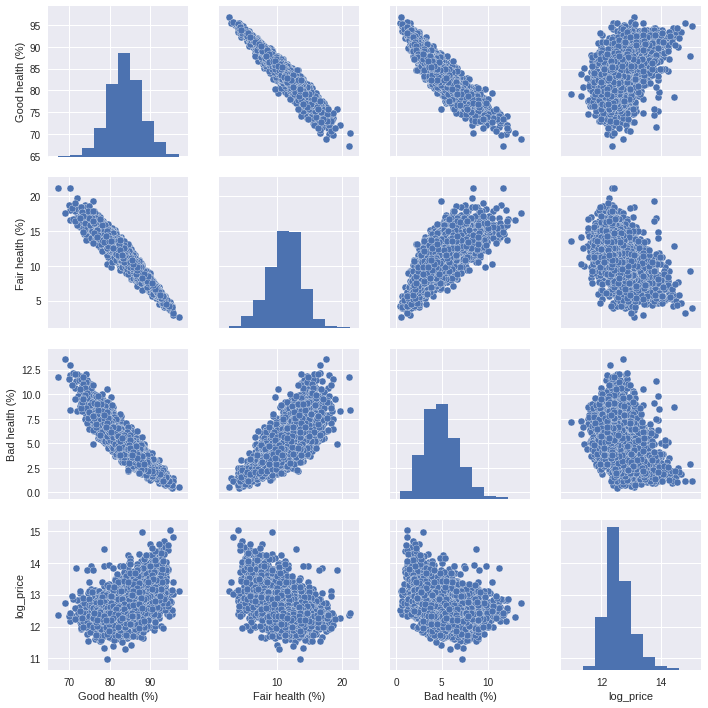

In [217]:
sns.pairplot(data = df[['Good health (%)','Fair health (%)', 'Bad health (%)', 'log_price']])

#### Access to public transport:

Average PTAL (%)     -0.137471
Poor PTAL (%)        -0.106496
Good PTAL (%)         0.219042
Average PTAL Score    0.224003
log_price             1.000000
Name: log_price, dtype: float64


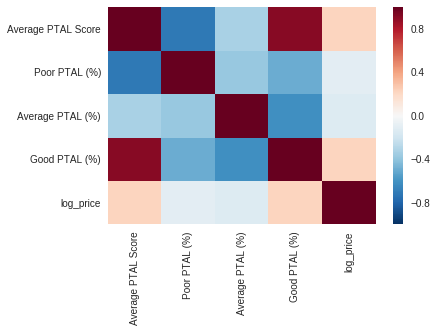

In [218]:
checkfeatures(['Average PTAL Score','Poor PTAL (%)', 'Average PTAL (%)', 'Good PTAL (%)'])

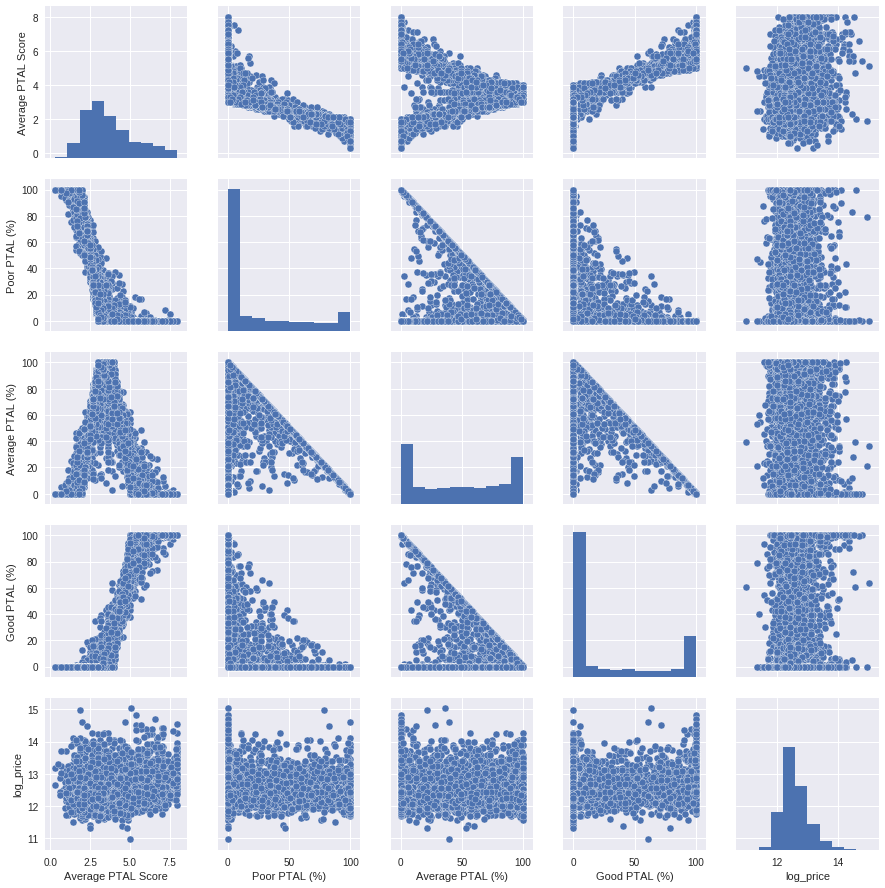

In [219]:
#Average PTAL score and percentage with good access look broadly similar, check pairwise distributions.
sns.pairplot(data = df[['Average PTAL Score','Poor PTAL (%)', 'Average PTAL (%)', 'Good PTAL (%)','log_price']])

In [0]:
#Individual PTAL score proportions are non linear, and will remain nonlinear under standard transformations
features.extend(['Average PTAL Score'])

#### Crime

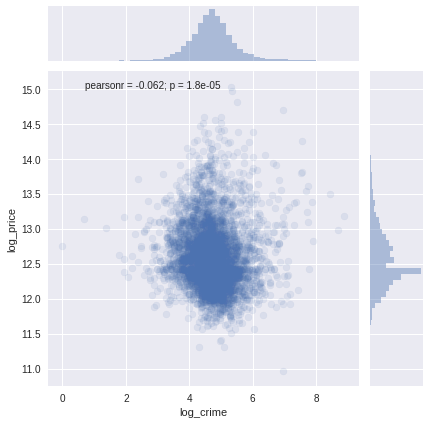

In [221]:
sns.jointplot(data = df, x='log_crime', y='log_price', alpha = 0.1)

As noted above, there is very little correlation between crime rates and house prices so I will omit them from my model

## 4.Predictive modelling
### 4.1 Linear Regression

We have the following features which appear to influence house prices to varying degrees.

In [222]:
print('Number of strong features :',len(features))
print(features)

Number of strong features : 16
['No. of Children', 'Ed: Higher (%)', 'Ed: GCSE D-F (%)', 'Employment Rate', 'Unemployment Rate', 'No usual residents (%)', 'Social rented (%)', 'Owned outright (%)', 'Terraced (%)', 'Detached (%)', 'WAVG_AGE', 'W_AVG_ROOMS', '4_BED', 'Good health (%)', 'Fair health (%)', 'Average PTAL Score']


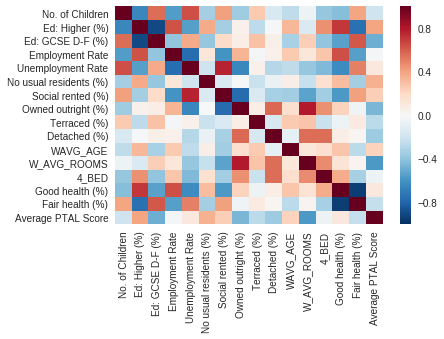

In [223]:
sns.heatmap(X_train[features].corr())

As you can see above, despite selecting features from different fields there are a number of features which are strongly positively or negatively correlated with each other. I will define a function to evaluate features on a passed X and y.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
pd.set_option('max_colwidth',100)

model = LinearRegression()

def evaluate_features (features, X, y):
    X = X[features]
    model = LinearRegression()
    cv_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-cv_scores)
    return np.mean(rmse_scores)

In [225]:
#In order to benchmark my models I will also need to make a basic prediction of the mean average of the ylog_training set.
#Raising this to the exponential returns the monetary average prediction

X_average = np.mean(ylog_train)
print(np.exp(X_average))

291458.59075655707


In [226]:
#Idenify the RMSE of the basic prediction

from sklearn.metrics import mean_squared_error

X_benchmark = [np.exp(X_average)] * len(ylog_test)

print("RMSE: ", np.sqrt(mean_squared_error(np.exp(ylog_test), X_benchmark)))

RMSE:  232533.74348385804


As a brute force method to decide which features to use in my linear regression I will define a function to iterate through combinations of features, store the results in a dataframe and return the model with the best set of features.

In [0]:
from itertools import combinations

def feature_combinator (features, X, y, n):
    
    listfeatures = []
    listscores = []

    for i in combinations(X[features].columns, n):
        listfeatures.append(i)
        listscores.append(evaluate_features(list(i), X, y))

    df_scores = pd.DataFrame({"features" : listfeatures, 'scores': listscores}, 
                             index = list(range(0,len(listscores)))).sort_values(by='scores', ascending = True)
    
    best_features = list(df_scores.iloc[0,0])
    
    lreg = LinearRegression()
    lreg.fit(X_train[best_features], ylog_train)
    
    print("Intercept: ",np.exp(lreg.intercept_),
          "\nRMSE: ", np.sqrt(mean_squared_error(np.exp(ylog_test), np.exp(lreg.predict(X_test[best_features])))),
          "\nCoefficients: ",  [z for z in zip(X[best_features].columns, lreg.coef_)])
    
    return (lreg, df_scores, best_features)

In [228]:
lreg_3features, df_3features, best_3features = feature_combinator(features, X_train, ylog_train, 3)

Intercept:  53519.88536298057 
RMSE:  170857.32924304443 
Coefficients:  [('Ed: Higher (%)', 0.025131360005773887), ('Social rented (%)', 0.010108906627649747), ('Owned outright (%)', 0.02347941543980974)]


In [229]:
lreg_4features, df_4features , best_4features = feature_combinator(features, X_train, ylog_train, 4)

Intercept:  51650.66216336762 
RMSE:  147253.9893058467 
Coefficients:  [('Ed: Higher (%)', 0.023021439429600016), ('No usual residents (%)', 0.025693578037134082), ('Social rented (%)', 0.010601260846383478), ('Owned outright (%)', 0.02424261586158597)]


In [230]:
lreg_5features, df_5features, best_5features = feature_combinator(features, X_train, ylog_train, 5)

Intercept:  39483.15817390207 
RMSE:  139571.91698660422 
Coefficients:  [('Ed: Higher (%)', 0.02176882904988602), ('No usual residents (%)', 0.027454089298786753), ('Social rented (%)', 0.012053486400284112), ('Owned outright (%)', 0.025095041331725527), ('WAVG_AGE', 0.0032607175807817523)]


In [231]:
lreg_6features, df_6features , best_6features = feature_combinator(features, X_train, ylog_train, 6)

Intercept:  25579.26047104237 
RMSE:  134925.81353547247 
Coefficients:  [('Ed: Higher (%)', 0.022529839752198234), ('No usual residents (%)', 0.0322140487668724), ('Social rented (%)', 0.011762372078526605), ('Owned outright (%)', 0.018929509327876945), ('WAVG_AGE', 0.0030284064927310547), ('W_AVG_ROOMS', 0.23094717242810592)]


In [232]:
#as a final test I will try a (likely overfitted) linear regression on all selected features

lreg_max = LinearRegression()
 
lreg_max.fit(X_train[features], ylog_train)
    
print("Intercept: ",np.exp(lreg_max.intercept_),
      "\nRMSE: ", np.sqrt(mean_squared_error(np.exp(ylog_test), np.exp(lreg_max.predict(X_test[features])))),
      "\nCoefficients: ",  [z for z in zip(X_train[features].columns, lreg_max.coef_)])
 

Intercept:  2859661.6935644303 
RMSE:  128326.00011742255 
Coefficients:  [('No. of Children', -0.00013507558886806712), ('Ed: Higher (%)', 0.012445531940154865), ('Ed: GCSE D-F (%)', -0.0215307576154062), ('Employment Rate', -0.005462908156791902), ('Unemployment Rate', -0.024836872241573868), ('No usual residents (%)', 0.02513345189180991), ('Social rented (%)', 0.011263896623566534), ('Owned outright (%)', 0.018395787307775732), ('Terraced (%)', -0.00021067958555378782), ('Detached (%)', -0.0012199267455426923), ('WAVG_AGE', 0.002615680626989064), ('W_AVG_ROOMS', 0.23162441462474015), ('4_BED', 0.00015414948129728948), ('Good health (%)', -0.032334976673160216), ('Fair health (%)', -0.06896653281043645), ('Average PTAL Score', 0.008805292355243109)]


Each model improves slightly by adding an extra feature, however the gains are diminishing, compuationally it takes much longer to add features and unsurprisingly the model keeps focussing on the same features as a starting point. The underlying features are consistent with each model indicating that these are the best features for a predictive model. I will save these 4 models as the best 'vanilla' linear regressions.

### 4.2 Ridge Regression

I will try to refine my best model above and also perform a 'dumb' ridge across all my selected features for comparison.

In [0]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def ridge_alpha_find (features, X, y):
    X = X[features]
    grid = GridSearchCV(estimator=Ridge(),
                        param_grid={'alpha': np.logspace(-10, 10, 21, base = 2)},
                        scoring='neg_mean_squared_error',
                        return_train_score=True,
                        cv=10)
    grid.fit(X,y)

    print(np.sqrt(-grid.best_score_), grid.best_params_)

In [0]:
features_list = [best_3features,best_4features,best_5features,best_6features]

In [235]:
for item in features_list:
    print(len(item))
    ridge_alpha_find (item, X_train,ylog_train)

3
0.282919606793681 {'alpha': 256.0}
4
0.27058687745757987 {'alpha': 64.0}
5
0.26162535500620676 {'alpha': 64.0}
6
0.25664248533096634 {'alpha': 2.0}


In [0]:
def ridge_fit (features, X_train, X_test, y_train, y_test, n):
    X_train = X_train[features]
    X_test = X_test[features]
    ridge = Ridge(alpha= n)
    ridge.fit(X_train, y_train)
    print("Intercept:",np.exp(ridge.intercept_),"\nRMSE:", np.sqrt(mean_squared_error(np.exp(y_test), 
                                                                             np.exp(ridge.predict(X_test)))))
    return ridge

In [237]:
rreg_3features = ridge_fit (best_3features, X_train, X_test, ylog_train, ylog_test, 256)

Intercept: 53679.28948440171 
RMSE: 170896.0444859365


In [238]:
rreg_4features = ridge_fit (best_4features, X_train, X_test, ylog_train, ylog_test, 64)

Intercept: 51693.14297080501 
RMSE: 147322.94142691325


In [239]:
rreg_5features = ridge_fit(best_5features, X_train, X_test, ylog_train, ylog_test, 64)

Intercept: 39520.4019301635 
RMSE: 139652.61723572834


In [240]:
rreg_6features = ridge_fit(best_4features, X_train, X_test, ylog_train, ylog_test, 2)

Intercept: 51651.99006110896 
RMSE: 147256.14826372123


No notable improvement on the vanilla linear regressions for 3-6 features. I will try a 'dumb' ridge regression across all features previously identified as being potentially useful.

In [241]:
ridge_alpha_find(features, X_train, ylog_train)

0.24405477521605598 {'alpha': 1.0}


In [242]:
rreg_dumb = ridge_fit(features,X_train, X_test, ylog_train, ylog_test, 1)

Intercept: 2848237.8578523677 
RMSE: 128318.8739518496


The 'dumb' ridge regression using all notable features has improved the RMSE compared to the linear models from 3-6 features. I will investigate the coefficients below:

In [243]:
df_rreg_coeff = pd.DataFrame({'Coefficients': rreg_dumb.coef_}, index = X_train[features].columns)
df_rreg_coeff.sort_values(by = 'Coefficients')

,Coefficients
Fair health (%),-0.068879
Good health (%),-0.032227
Unemployment Rate,-0.024839
Ed: GCSE D-F (%),-0.021514
Employment Rate,-0.005479
Detached (%),-0.001218
Terraced (%),-0.000198
No. of Children,-0.000135
4_BED,0.000159
WAVG_AGE,0.002618


Interestingly the ridge has focussed on the weighted average number of rooms whereas this was only the 6th feature added to the linear regressions above. A number of the coefficents have been collapsed to less than 0.001. I will also apply a ridge regression to the full data.

In [244]:
ridge_alpha_find(X_train.columns, X_train, ylog_train)

0.23125187713605136 {'alpha': 2.0}


In [245]:
rreg_full = ridge_fit(X_train.columns,X_train, X_test, ylog_train, ylog_test, 2)

Intercept: 36082307.67088032 
RMSE: 112827.39117143312


In [246]:
df_rreg_coeff = pd.DataFrame({'Coefficients': rreg_full.coef_}, index = X_train.columns)
df_rreg_coeff.sort_values(by = 'Coefficients')

,Coefficients
Good PTAL (%),-0.043337
Average PTAL (%),-0.042729
Poor PTAL (%),-0.041783
Unemployment Rate,-0.039385
Schoolchildren (%),-0.030354
Employment Rate,-0.020609
Ed: GCSE A-C (%),-0.018379
Ed: GCSE D-F (%),-0.016935
Fair health (%),-0.013962
Owned mortgaged (%),-0.012896


Across all features the ridge appears to have improved its' score again, however this may be overfitting.

### 4.3 Lasso regression

I will fit a Lasso regression on the key features and on the full feature set to see if this method provides a different set of key features

In [0]:
from sklearn.linear_model import Lasso

def lasso_alpha_find (features, X, y):
    X = X[features]
    grid = GridSearchCV(estimator=Lasso(),
                        param_grid={'alpha': np.logspace(-10, 10, 21)},
                        scoring='neg_mean_squared_error',
                        return_train_score=True,
                        cv=5)
    grid.fit(X,y)

    print(np.sqrt(-grid.best_score_), grid.best_params_)

In [248]:
lasso_alpha_find(features, X_train, ylog_train)

0.24413771575137785 {'alpha': 1e-10}


In [249]:
lasso_dumb = Lasso(alpha = 1e-10)
lasso_dumb.fit(X_train[features], ylog_train)
print("Intercept:",np.exp(lasso_dumb.intercept_),"\nRMSE:", 
      np.sqrt(mean_squared_error(np.exp(ylog_test), np.exp(lasso_dumb.predict(X_test[features])))))
pd.DataFrame({ 'Coefficients': lasso_dumb.coef_}, index = X_train[features].columns).sort_values(by = 'Coefficients')

Intercept: 2859661.6220711456 
RMSE: 128326.00012220633


,Coefficients
Fair health (%),-0.068967
Good health (%),-0.032335
Unemployment Rate,-0.024837
Ed: GCSE D-F (%),-0.021531
Employment Rate,-0.005463
Detached (%),-0.001220
Terraced (%),-0.000211
No. of Children,-0.000135
4_BED,0.000154
WAVG_AGE,0.002616


Lasso across the identified features produces almost the same result as ridge. I will not replicate this across the whole dataset as it is unlikely to add any further value to the Ridge regressions already modelled, and Lasso is only really appropriate when features >> samples.

### 5.1 Random forest modelling

An alternative approach to prediction is using a random forest approach. I will revert to my non-transformed data as decision trees don't require normally distributed data. For a first attempt I will aim for 10 samples per leaf. 100 trees seems sufficiently large to mitigate variances 10 features per split seems like a good place to start.

In [250]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, max_features = 10)
scores = cross_val_score(rfreg, X_train[features], yreg_train, cv=10, scoring="neg_mean_squared_error")
print("RMSE: ",np.sqrt(np.mean(-scores)))

RMSE:  129127.75046304826


In [251]:
#Our tree performs in line wih the better linear regressions modelled so far. Check features
rfreg.fit(X_train[features],yreg_train)
pd.DataFrame({'Feature':X_train[features].columns, 
              'Importance':rfreg.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
1,Ed: Higher (%),0.193692
2,Ed: GCSE D-F (%),0.184371
5,No usual residents (%),0.121896
0,No. of Children,0.108241
7,Owned outright (%),0.106596
12,4_BED,0.085665
11,W_AVG_ROOMS,0.058932
10,WAVG_AGE,0.034410
13,Good health (%),0.017440
14,Fair health (%),0.015269


In [0]:
#I will use another GridSearch to refine my random forest model:
def random_forest_optimiser(features, X_train, X_test, y_train, y_test):
    grid = GridSearchCV(estimator=RandomForestRegressor(),
                        param_grid={"min_samples_leaf": [3, 5, 10, 15],
                                    "max_features": list(range(3,len(X_train[features].columns),3))},
                        scoring="neg_mean_squared_error",
                        cv=10)

    grid.fit(X_train[features], y_train)
    
    print('CV score: ',np.sqrt(-grid.best_score_), grid.best_params_)
    best_model = grid.best_estimator_
    print('RMSE:' ,np.sqrt(mean_squared_error(y_test,best_model.predict(X_test[features]))))
    df_features = pd.DataFrame({'Feature':X_train[features].columns, 
              'Importance':best_model.feature_importances_}).sort_values(by='Importance', ascending=False)
    return best_model, df_features

In [253]:
randf, df_randf_features = random_forest_optimiser(features, X_train, X_test, yreg_train, yreg_test)

df_randf_features.head(10)

CV score:  127623.72472587947 {'max_features': 12, 'min_samples_leaf': 5}
RMSE: 109398.47538719412


,Feature,Importance
2,Ed: GCSE D-F (%),0.157339
0,No. of Children,0.147942
5,No usual residents (%),0.133572
7,Owned outright (%),0.129012
1,Ed: Higher (%),0.127270
12,4_BED,0.074253
11,W_AVG_ROOMS,0.054344
10,WAVG_AGE,0.035922
8,Terraced (%),0.029170
4,Unemployment Rate,0.019654


In [254]:
randf_full , df_randf_full = random_forest_optimiser(X_train.columns, X_train, X_test, yreg_train, yreg_test)

df_randf_full.head(10)

CV score:  126018.45072502144 {'max_features': 24, 'min_samples_leaf': 5}
RMSE: 114765.79972134135


,Feature,Importance
18,Ed: GCSE D-F (%),0.230442
22,Ed: Higher (%),0.112726
5,Owned outright (%),0.096157
32,No. of Children,0.084001
35,4_BED,0.055579
10,No usual residents (%),0.043743
33,W_AVG_ROOMS,0.037320
6,Owned mortgaged (%),0.033747
14,Flats etc (%),0.031786
9,Usual residents (%),0.030461


The full random forest model performed slightly better but has identified different important features. This may be overfitted so I will select the top 10 features for a further random forest to see if this works better.

In [255]:
top_features = list(df_randf_full.iloc[:10,0])
randf_top , df_randf_top10 = random_forest_optimiser(top_features, X_train,
                                                      X_test, yreg_train, yreg_test)

df_randf_top10.head(10)

CV score:  129120.25635575301 {'max_features': 9, 'min_samples_leaf': 3}
RMSE: 118166.93875072995


,Feature,Importance
0,Ed: GCSE D-F (%),0.192980
1,Ed: Higher (%),0.176321
3,No. of Children,0.121686
4,4_BED,0.121018
2,Owned outright (%),0.102336
9,Usual residents (%),0.072366
6,W_AVG_ROOMS,0.065675
5,No usual residents (%),0.058628
7,Owned mortgaged (%),0.051789
8,Flats etc (%),0.037202


Limiting the features actuall impeded the random forest's performance, however all models had a higher CV score than the final RMSE on the test data (implying underfitting??)

### 5.2 Gradient boosted random forest


In [256]:
from sklearn.ensemble import GradientBoostingRegressor

gbrf = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_features = 10)
scores = cross_val_score(gbrf, X_train[features], yreg_train, cv=10, scoring="neg_mean_squared_error")
print("RMSE: ",np.sqrt(np.mean(-scores)))

RMSE:  126654.28687819593


In [257]:
#Gradient boosted non-tuned model is marginally better than the standard random forest regressor. Again lets review features:

gbrf.fit(X_train[features],yreg_train)
pd.DataFrame({'Feature':X_train[features].columns, 
              'Importance':gbrf.feature_importances_}).sort_values(by='Importance', ascending=False)


,Feature,Importance
2,Ed: GCSE D-F (%),0.192751
0,No. of Children,0.157708
5,No usual residents (%),0.120864
12,4_BED,0.114068
1,Ed: Higher (%),0.106567
7,Owned outright (%),0.103716
11,W_AVG_ROOMS,0.068138
10,WAVG_AGE,0.037897
13,Good health (%),0.016615
4,Unemployment Rate,0.016270


In [0]:
#Feature importances are broadly in line with the random forest regressor, however the coefficients tend to nil much quicker 
#I will use another GridSearch to refine my gradient boosted random forest model:
def gbrf_optimiser(features, X_train, X_test, y_train, y_test):
    grid = GridSearchCV(estimator=GradientBoostingRegressor(),
                        param_grid={"min_samples_leaf": [3, 5, 10, 15],
                                    "max_features": list(range(3,len(X_train[features].columns),3))},
                        scoring="neg_mean_squared_error",
                        cv=10)

    grid.fit(X_train[features], y_train)
    
    print('CV score: ',np.sqrt(-grid.best_score_), grid.best_params_)
    best_model = grid.best_estimator_
    print('RMSE:' ,np.sqrt(mean_squared_error(y_test,best_model.predict(X_test[features]))))
    df_features = pd.DataFrame({'Feature':X_train[features].columns, 
              'Importance':best_model.feature_importances_}).sort_values(by='Importance', ascending=False)
    return best_model, df_features

In [259]:
gbrf, df_gbrf_features = gbrf_optimiser(features, X_train, X_test, yreg_train, yreg_test)

df_gbrf_features.head(10)

CV score:  123525.25664317005 {'max_features': 12, 'min_samples_leaf': 3}
RMSE: 110786.62330105533


,Feature,Importance
2,Ed: GCSE D-F (%),0.166691
0,No. of Children,0.149061
5,No usual residents (%),0.122220
12,4_BED,0.107896
7,Owned outright (%),0.107780
1,Ed: Higher (%),0.098706
14,Fair health (%),0.067534
11,W_AVG_ROOMS,0.061897
10,WAVG_AGE,0.034964
6,Social rented (%),0.023335


In [260]:
#The gradient boosted random forest performed in line with the random forest regressor over the selected features, ordering and coefficients is different however. 
#If we open up to the full feature set, this may again decrease performance due to overfiting.

gbrf_full , df_gbrf_full = gbrf_optimiser(X_train.columns, X_train, X_test, yreg_train, yreg_test)

df_gbrf_full.head(10)

CV score:  119763.67798224524 {'max_features': 15, 'min_samples_leaf': 5}
RMSE: 107969.005698663


,Feature,Importance
18,Ed: GCSE D-F (%),0.126628
22,Ed: Higher (%),0.123363
32,No. of Children,0.107261
35,4_BED,0.103412
9,Usual residents (%),0.099898
5,Owned outright (%),0.083131
33,W_AVG_ROOMS,0.048097
16,Unemployment Rate,0.038908
10,No usual residents (%),0.037072
6,Owned mortgaged (%),0.020563


In [261]:
#Again this may be overfitted, so just restricting to the top 10 features across the dataset.

gbrf_top_features = list(df_gbrf_full.iloc[:10,0])
gbrf_top , df_gbrf_top10 = random_forest_optimiser(gbrf_top_features, X_train,
                                                      X_test, yreg_train, yreg_test)

df_gbrf_top10.head(10)

CV score:  129077.16405335546 {'max_features': 9, 'min_samples_leaf': 5}
RMSE: 122583.87551308353


,Feature,Importance
1,Ed: Higher (%),0.231231
0,Ed: GCSE D-F (%),0.177878
3,4_BED,0.121905
5,Owned outright (%),0.112958
2,No. of Children,0.095925
6,W_AVG_ROOMS,0.073951
4,Usual residents (%),0.068709
8,No usual residents (%),0.049081
9,Owned mortgaged (%),0.045420
7,Unemployment Rate,0.022941


Again this decreases the performance of the model (as expected!)

### 6 Testing the models against the master testing set

All of the models so far have been trained on a subset of the full data, I will now test the best 3 models from each method on the master testing set to measure overall performance.

In [0]:
test_log_models = [lreg_4features,lreg_5features,lreg_6features,rreg_5features,rreg_dumb,rreg_full]
test_log_features = [best_4features, best_5features, best_6features, best_5features, features, X.columns]
test_log_modelnames = ['4 feature linear', '5 feature linear', '6 feature linear', 
                          '5 feature ridge','dumb ridge', 'full ridge']

In [263]:
for i in range(0,len(test_log_models)):
               print(test_log_modelnames[i], 'RMSE: ',
                     np.sqrt(mean_squared_error(y_test_master['Median price 2011'],
                                                np.exp(test_log_models[i].predict(X_test_master[test_log_features[i]])))))

4 feature linear RMSE:  118313.85850691955
5 feature linear RMSE:  113885.32591512357
6 feature linear RMSE:  110193.09010240228
5 feature ridge RMSE:  113902.87276269734
dumb ridge RMSE:  103819.6786653143
full ridge RMSE:  96168.06221667063


In [0]:
test_reg_models = [randf,randf_full,randf_top,gbrf,gbrf_full,gbrf_top]
test_reg_features = [features, X.columns, top_features,features, X.columns, gbrf_top_features]
test_reg_modelnames = ['selected random forest', 'full random forest', 'top features random forest','selected gb forest', 'full gb forest', 'top features gb forest']

In [295]:
for i in range(0,len(test_reg_models)):
               print(test_reg_modelnames[i], 'RMSE: ',
                     np.sqrt(mean_squared_error(y_test_master['Median price 2011'],
                                                test_reg_models[i].predict(X_test_master[test_reg_features[i]]))))

selected random forest RMSE:  108160.18181112595
full random forest RMSE:  103568.56095799954
top features random forest RMSE:  106001.28318659676
selected gb forest RMSE:  104943.73703418022
full gb forest RMSE:  100148.10835855827
top features gb forest RMSE:  111527.77763772514


Performance on the master testing set is broadly in line with that of the training splits, therefore the models are not seen to experience great variance.

### 7. Residuals

I will calculate the residuals by LSOA to confirm if they are normally distributed (validating the bias of the model) and identify if there are any common trends between the different approaches

In [0]:
test_models = [lreg_4features,lreg_5features,lreg_6features,rreg_5features,rreg_dumb,
          rreg_full,randf,randf_full,randf_top,gbrf,gbrf_full,gbrf_top]

test_features = [best_4features, best_5features, best_6features, best_5features, 
                 features, X.columns, features, X.columns, top_features,features, X.columns, gbrf_top_features ]

In [0]:
df_predictions= y.copy()

for i in range(0,len(test_models)):
    df_predictions[i] = test_models[i].predict(X[test_features[i]])

In [0]:

df_predictions.drop(columns= 'log_price', inplace = True)
df_predictions.columns = ['Median price 2011','4 feature linear', '5 feature linear', '6 feature linear', 
                          '5 feature ridge','selected ridge', 'full ridge', 'selected forest', 'full forest', 'top forest','selected gb forest', 'full gb forest', 'top gb forest']
df_predictions.iloc[:,1:7] = np.exp(df_predictions.iloc[:,1:7])

In [293]:
pd.options.display.float_format = '{:,.0f}'.format

df_predictions.head()

,Median price 2011,4 feature linear,5 feature linear,6 feature linear,5 feature ridge,selected ridge,full ridge,selected forest,full forest,top forest,selected gb forest,full gb forest,top gb forest
LSOA,,,,,,,,,,,,,
E01000907,415000,"349,696","343,143","333,936","343,145","339,727","335,245","438,168","392,367","382,234","423,122","352,692","359,104"
E01000908,282500,"457,207","495,462","460,810","495,313","467,200","400,645","401,257","376,061","355,945","416,076","391,387","358,601"
E01000909,435000,"704,065","726,547","732,293","726,403","723,646","737,631","549,151","429,917","749,407","653,745","608,860","621,756"
E01000912,500000,"396,170","428,317","443,746","428,275","411,666","381,071","462,280","400,762","399,634","400,624","371,272","458,528"
E01000913,1000000,"964,987","981,073","971,238","980,442","952,930","908,806","1,658,292","1,244,678","1,661,882","1,472,426","1,445,189","1,479,315"


In [0]:
df_residuals = -df_predictions.sub(df_predictions['Median price 2011'], axis=0)

# I have several models which are trained on similar fields in the data, in order to identify consistent outliers I will only use my most effective model of each type

df_residuals.drop (columns = ['Median price 2011', '4 feature linear', '5 feature linear', '5 feature ridge', 'selected ridge', 'selected forest', 'top forest' , 'selected gb forest', 'top gb forest'], inplace = True)

In [331]:
#A positive residual indicates the model predicted a lower price than than actual. A negative residual indicates the model predicted a higher price (and therefore the location may be undervalued)
df_residuals.head()

,6 feature linear,full ridge,full forest,full gb forest
LSOA,,,,
E01000907,"81,064.367","79,754.659","22,633.421","62,308.442"
E01000908,"-178,309.737","-118,144.554","-93,560.959","-108,886.947"
E01000909,"-297,293.159","-302,630.653","5,082.782","-173,859.897"
E01000912,"56,253.584","118,928.704","99,237.821","128,727.834"
E01000913,"28,762.012","91,194.251","-244,677.509","-445,189.025"


In [332]:
df_residuals.describe()

,6 feature linear,full ridge,full forest,full gb forest
count,"4,821.000","4,821.000","4,821.000","4,821.000"
mean,"16,297.816","12,509.764",569.123,739.276
std,"132,123.913","112,304.713","97,005.816","89,661.775"
min,"-604,905.275","-508,431.681","-636,786.166","-511,376.533"
25%,"-36,797.264","-34,405.988","-34,100.780","-38,368.708"
50%,-555.303,785.311,"-6,680.915","-6,638.168"
75%,"39,275.952","36,689.758","18,276.790","28,780.867"
max,"2,346,079.798","2,206,896.993","1,573,373.682","1,107,791.783"


The residual mean and medians are small compared to the RMSE and therefore I can conlcude that the models do not suffer from significant bias. 

The linear regression models appear to be slightly skewed positively as the means are greater than the medians. The absolute values of their medians are less than £1k indicating low bias. The forest models appear to also be positively skewed as the means are again greater than the medians, this time the medians are around -£6k indicating a slight negative bias.

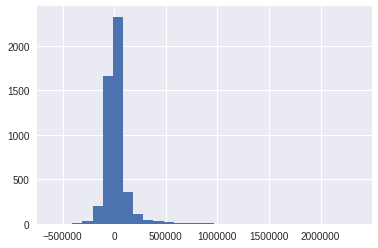

In [333]:
df_residuals['6 feature linear'].hist(bins = 30)

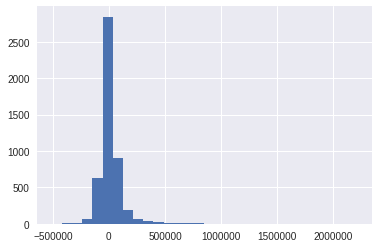

In [334]:
df_residuals['full ridge'].hist(bins = 30)

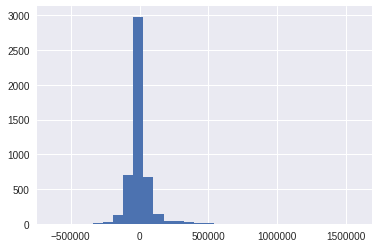

In [335]:
df_residuals['full forest'].hist(bins = 30)

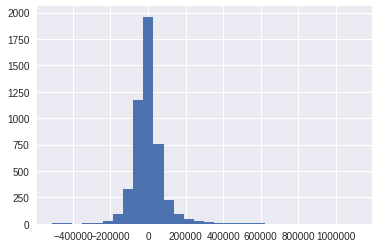

In [336]:
df_residuals['full gb forest'].hist(bins = 30)

From inspecting the histograms, each of the selected models appear to be normally distributed so appropriately fitted. Reviewing the residuals for consistent outliers with negative residuals will indicate LSOAs which are underpriced.

In [0]:
df_residuals = df_price.join(df_residuals, how = 'inner').drop(columns = 'log_price', axis = 1)

In [0]:
#As well as looking at absolute values, the residuals can be considered proportionally to the price they were supposed to be predicting.
#We add columns for normalised residuals.

df_residuals['Average residual'] = df_residuals[['6 feature linear','full ridge','full forest','full gb forest']].mean(axis = 1)

for i in range (1,5):
    df_residuals['Norm_res_'+ str(i)] = df_residuals.iloc[:,i]/df_residuals.iloc[:,0]
    
df_residuals['Average normal residual'] = df_residuals[['Norm_res_1','Norm_res_2','Norm_res_3','Norm_res_4']].mean(axis = 1)

In [339]:
pd.options.display.float_format = '{:,.3f}'.format
df_residuals.head()

,Median price 2011,6 feature linear,full ridge,full forest,full gb forest,Average residual,Norm_res_1,Norm_res_2,Norm_res_3,Norm_res_4,Average normal residual
LSOA,,,,,,,,,,,
E01000907,415000,"81,064.367","79,754.659","22,633.421","62,308.442","61,440.222",0.195,0.192,0.055,0.150,0.148
E01000908,282500,"-178,309.737","-118,144.554","-93,560.959","-108,886.947","-124,725.549",-0.631,-0.418,-0.331,-0.385,-0.442
E01000909,435000,"-297,293.159","-302,630.653","5,082.782","-173,859.897","-192,175.232",-0.683,-0.696,0.012,-0.400,-0.442
E01000912,500000,"56,253.584","118,928.704","99,237.821","128,727.834","100,786.985",0.113,0.238,0.198,0.257,0.202
E01000913,1000000,"28,762.012","91,194.251","-244,677.509","-445,189.025","-142,477.568",0.029,0.091,-0.245,-0.445,-0.142


In [347]:
location = pd.read_csv("https://raw.githubusercontent.com/achaterlea/london_data/master/LSOAcentres.csv")
location.columns = ['X', 'Y', 'Num', 'LSOA', 'Area' ]
location.set_index(['LSOA'], inplace = True)
df_with_location = location.join(df_residuals[['Median price 2011','Average residual','Average normal residual']], how='inner')
df_with_location.head(10)

,X,Y,Num,Area,Median price 2011,Average residual,Average normal residual
LSOA,,,,,,,
E01000056,0.137,51.534,19347,Barking and Dagenham 018C,155000,"-13,186.541",-0.085
E01000057,0.127,51.538,19348,Barking and Dagenham 012A,152500,"-35,479.774",-0.233
E01000054,0.132,51.537,19349,Barking and Dagenham 018A,159500,"-16,303.766",-0.102
E01000055,0.126,51.536,19350,Barking and Dagenham 018B,152000,"-20,622.225",-0.136
E01000052,0.093,51.533,19351,Barking and Dagenham 019D,149500,"-47,628.532",-0.319
E01000053,0.143,51.533,19352,Barking and Dagenham 020A,112000,"-45,291.794",-0.404
E01000050,0.086,51.535,19353,Barking and Dagenham 019C,188500,"-40,075.432",-0.213
E01000051,0.082,51.534,19354,Barking and Dagenham 021D,137000,"-66,956.537",-0.489
E01000058,0.136,51.539,19355,Barking and Dagenham 018D,168000,"-8,483.459",-0.050


Now we have the average residual percentage paired up with location data we can start identifying areas which are consistently underpriced by the selected models.

In [348]:
#In normalised terms, the following are the top 20 'underpriced' areas
df_with_location.sort_values(by = 'Average normal residual', ascending = True).head(20)

,X,Y,Num,Area,Median price 2011,Average residual,Average normal residual
LSOA,,,,,,,
E01003689,0.074,51.555,20669,Redbridge 030G,58000,"-176,988.081",-3.052
E01001712,0.057,51.493,20019,Greenwich 004D,88500,"-118,502.203",-1.339
E01000855,-0.125,51.522,21112,Camden 028A,225000,"-300,013.960",-1.333
E01001705,0.057,51.489,21507,Greenwich 005A,81500,"-100,031.651",-1.227
E01003993,-0.104,51.482,22985,Southwark 017D,130000,"-150,807.854",-1.160
E01001224,-0.319,51.519,20144,Ealing 019B,360000,"-417,180.204",-1.159
E01000466,0.130,51.496,22988,Bexley 001A,90500,"-103,149.663",-1.140
E01032772,-0.023,51.500,22264,Tower Hamlets 032C,172000,"-188,215.723",-1.094
E01004619,-0.172,51.449,22431,Wandsworth 015E,331000,"-361,936.428",-1.093


So proportionally, these were the areas where the actual median price paid in 2011 represented the biggest % saving compared to the model predicted prices. Ie - the demographics and other characteristics of the area leads the model to predict that house prices should have been much higher (in 2011). Interestingly, areas to the south and east feature relatively prominently, which have a reputation for being more affordable places to live - indicating the model has some credibility in predicting outliers.

In [350]:
#In absolute terms, the following are the top 20 'underpriced' areas
df_with_location.sort_values(by = 'Average residual', ascending = True).head(20)

,X,Y,Num,Area,Median price 2011,Average residual,Average normal residual
LSOA,,,,,,,
E01004680,-0.165,51.514,19726,Westminster 015A,660000,"-471,215.702",-0.714
E01001224,-0.319,51.519,20144,Ealing 019B,360000,"-417,180.204",-1.159
E01004619,-0.172,51.449,22431,Wandsworth 015E,331000,"-361,936.428",-1.093
E01000212,-0.194,51.578,23790,Barnet 035D,600000,"-359,391.977",-0.599
E01000855,-0.125,51.522,21112,Camden 028A,225000,"-300,013.960",-1.333
E01000568,-0.319,51.578,20370,Brent 008D,300000,"-292,333.887",-0.974
E01001049,-0.074,51.372,22455,Croydon 023C,380000,"-285,860.544",-0.752
E01002862,-0.168,51.492,24009,Kensington and Chelsea 014E,250000,"-261,454.362",-1.046
E01002995,-0.303,51.387,21419,Kingston upon Thames 013D,365000,"-261,208.463",-0.716


In absolute terms, the areas identified as outliers tend to feature in more expensive areas for property to begin with. it would be interesting to see how these averages compared to prices in other years and whether the 2011 median price paid was an anomaly.

To finish, we can review the underpriced areas plotted by hue on a longitude and latitude basis (darker is 'over priced' according to the model.)

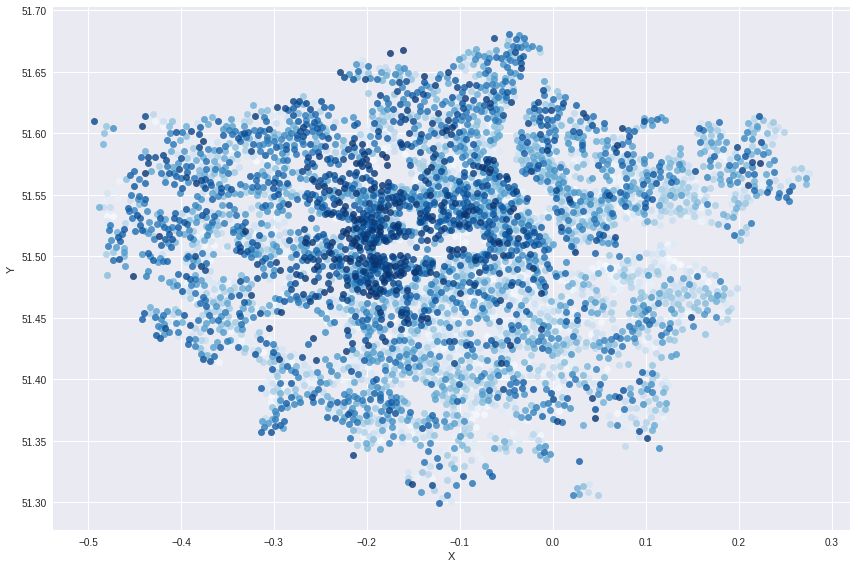

In [352]:
sns.lmplot(data = df_with_location, x= 'X', y = 'Y', fit_reg = False, hue = 'Average normal residual', legend=False, 
           size = 8, aspect = 1.5, palette = "Blues")